# RSNA 2024 Lumbar Spine Degenerative Classification

## Data Loading

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom as dicom

from tqdm import tqdm


In [2]:
# read data
train_path = 'rsna_data/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [3]:
print("train shape :", train.shape)
print("train label shape :", label.shape)
print("train descriptions shape :", train_desc.shape)
print("test descriptions shape :", test_desc.shape)
print("submission shape :", sub.shape)

train shape : (1975, 26)
train label shape : (48692, 7)
train descriptions shape : (6294, 3)
test descriptions shape : (3, 3)
submission shape : (25, 4)


In [4]:
def number_of_images(directory):
    return sum([len(files) for r, d, files in os.walk(directory) if any(f.endswith('.dcm') for f in files)])

print("n of training images \t:", number_of_images(f'{train_path}/train_images'))
print("n of test images \t:", number_of_images(f'{train_path}/test_images'))


# values with more than 4 series Id. They still have only 3 types of images.
train_desc[train_desc['study_id'] == 10728036]
train_desc[train_desc['study_id'] == 1009445512]

n of training images 	: 147218
n of test images 	: 97


,study_id,series_id,series_description
1468,1009445512,1705522953,Axial T2
1469,1009445512,2883858173,Sagittal T2/STIR
1470,1009445512,3088482668,Sagittal T1
1471,1009445512,4018190332,Axial T2


In [5]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [6]:
# number of images with at least one annotation
unique_count = label[['series_id', 'instance_number']].drop_duplicates().shape[0]
unique_count

24546

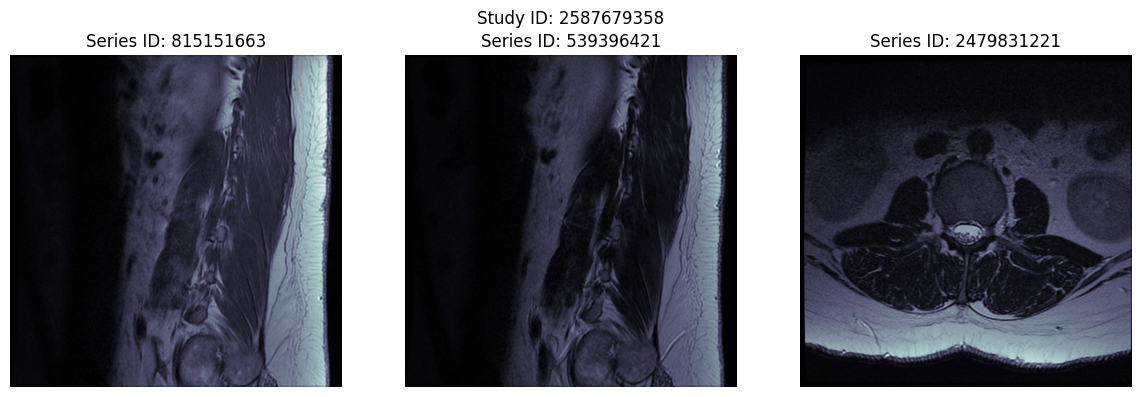

In [7]:
def display_dicom_with_coordinates(study_id, image_paths, label_df, exact_image = True):

    fig, axs = plt.subplots(1, len(image_paths), figsize=(12,4))
    for index, (series_id, instance_number, path) in enumerate(image_paths):

        ds = dicom.dcmread(path)
        axs[index].imshow(ds.pixel_array, cmap=plt.cm.bone)
        axs[index].set_title(f'Series ID: {series_id}')
        axs[index].axis('off')

        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]
        if exact_image:
            filtered_labels = filtered_labels[filtered_labels['instance_number'] == instance_number]

        for _, row in filtered_labels.iterrows():
            axs[index].plot(row['x'], row['y'], 'ro', markersize = 3)

    fig.suptitle(f'Study ID: {study_id}')
    plt.tight_layout()
    plt.show()

study_id = train['study_id'].sample(n=1).iloc[0]
study_folder = f'{train_path}/train_images/{study_id}'
image_paths = []
for series_id in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_id)
    if not os.path.isdir(series_folder_path) : continue

    for f in os.listdir(series_folder_path):
        if f.endswith('.dcm'):
            file = f
            break

    instance_number = int(file.split('.')[0])
    image_paths.append((int(series_id), instance_number, os.path.join(series_folder_path, file)))

display_dicom_with_coordinates(int(study_id), image_paths, label)

## Data Preprocessing

In [8]:
train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [9]:
# unrolling the data with each study id having 25 rows
def reshape_row(row):
    data = {'study_id':[], 'condition':[], 'level':[], 'severity':[]}

    for column, value in row.items():
        if column not in ['study_id','series_id', 'instance_number', 'x', 'y', 'series_description']: # tidy elements : study_id는 그대로
            parts = column.split('_') # spinal_canal_stenosis_l1_l2 -> ['spinal', 'canal', 'stenosis', 'l1', 'l2']
            condition = ' '.join([word.capitalize() for word in parts[:-2]]) # ['spinal', 'canal', 'stenosis'] -> 'Spinal Canal Stenosis'
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize() # ['l1', 'l2'] -> 'L1/L2'
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)

    return pd.DataFrame(data)

new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

#validate if the size of long form is number of study id multiplied by 25
assert new_train_df.shape[0] == train.shape[0] * 25, 'Some issues with format conversion!'
new_train_df.head(26)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild


Now to see if we have specific images for each type.

In [10]:
# new_train_df, label, train_desc
print("\nColumns in new_train_df:")
print(", ".join(new_train_df.columns))

print("\nColumns in label:")
print(", ".join(label.columns))

print("\nColumns in train_desc:")
print(", ".join(train_desc.columns))

print("\nColumns in sub:")
print(", ".join(sub.columns))


Columns in new_train_df:
study_id, condition, level, severity

Columns in label:
study_id, series_id, instance_number, condition, level, x, y

Columns in train_desc:
study_id, series_id, series_description

Columns in sub:
row_id, normal_mild, moderate, severe


In [11]:
pd.crosstab([new_train_df['condition'], new_train_df['level']], new_train_df['severity'], margins=True)

severity                                Moderate  Normal/Mild  Severe    All
condition                        level                                      
Left Neural Foraminal Narrowing  L1/L2        63         1908       2   1973
                                 L2/L3       171         1791      11   1973
                                 L3/L4       411         1522      40   1973
                                 L4/L5       629         1204     140   1973
                                 L5/S1       520         1247     206   1973
Left Subarticular Stenosis       L1/L2        93         1690      28   1811
                                 L2/L3       255         1555      83   1893
                                 L3/L4       454         1324     194   1972
                                 L4/L5       624          887     461   1972
                                 L5/S1       409         1408     147   1964
Right Neural Foraminal Narrowing L1/L2        63         1891      13   1967
                                 L2/L3       168         1793       6   1967
                                 L3/L4       414         1512      41   1967
                                 L4/L5       629         1208     130   1967
                                 L5/S1       496         1281     190   1967
Right Subarticular Stenosis      L1/L2       110         1680      24   1814
                                 L2/L3       243         1577      73   1893
                                 L3/L4       454         1322     197   1973
                                 L4/L5       622          891     460   1973
                                 L5/S1       396         1399     173   1968
Spinal Canal Stenosis            L1/L2        67         1886      21   1974
                                 L2/L3       151         1770      53   1974
                                 L3/L4       230         1622     122   1974
                                 L4/L5       237         1482     255   1974
                                 L5/S1        51         1904      19   1974
All                                         7960        37754    3089  48803

To get more information about each type of image and what that image predicts, lets merge this with label and train_series_desc

In [12]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [13]:
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
print(final_merged_df.shape)
final_merged_df.head(25)

(48692, 9)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,12,191.321555,170.120141,Sagittal T1
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,1054713880,12,187.878354,217.245081,Sagittal T1
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,11,186.504472,251.592129,Sagittal T1
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,11,197.100569,289.457306,Sagittal T1


In [14]:
pd.crosstab(final_merged_df['condition'], final_merged_df['series_description'])

series_description,Axial T2,Sagittal T1,Sagittal T2/STIR
condition,,,
Left Neural Foraminal Narrowing,0,9860,0
Left Subarticular Stenosis,9608,0,0
Right Neural Foraminal Narrowing,0,9859,0
Right Subarticular Stenosis,9612,0,0
Spinal Canal Stenosis,0,5,9748


In [15]:
final_merged_df['severity'].value_counts()

severity
Normal/Mild    37626
Moderate        7950
Severe          3081
Name: count, dtype: int64

### There is a clear pattern. Each condition is being identified using a specific series i.e. one specific kind of scan.
### Lets delete the 5 series data that used sagittal T1 for predicting Spinal Canal Stenosis as an exception.

In [16]:
df_filtered = final_merged_df[~((final_merged_df['condition'] == 'Spinal Canal Stenosis') & (final_merged_df['series_description'] == 'Sagittal T1'))]
final_merged_df = df_filtered
pd.crosstab(df_filtered['condition'], df_filtered['series_description'])

series_description,Axial T2,Sagittal T1,Sagittal T2/STIR
condition,,,
Left Neural Foraminal Narrowing,0,9860,0
Left Subarticular Stenosis,9608,0,0
Right Neural Foraminal Narrowing,0,9859,0
Right Subarticular Stenosis,9612,0,0
Spinal Canal Stenosis,0,0,9748


In [17]:
final_merged_df['severity'].value_counts()

severity
Normal/Mild    37623
Moderate        7949
Severe          3080
Name: count, dtype: int64

We deleted 1 each of type Moderate and Severe and 3 of type Normal/Mild. This seems fine, as we would not want more of severe or moderate to be deleted.

### Now dropping the duplicates.

labels.csv has rows of different instances with X Y Coordinates that pinpoint where the problem is at. Since, X Y coordinate for all images/instances are not available, we will not use those coordinates. For generating the complete training dataset, we will read images/instances directly from the folder.

In [18]:
final_merged_df = final_merged_df.drop_duplicates(subset=['study_id', 'condition', 'series_id']).reset_index(drop=True)
print(final_merged_df.shape)
final_merged_df.head()

(10252, 9)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
2,4003253,Right Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,6,194.569790,127.755258,Sagittal T1
3,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,3,179.126448,161.235521,Axial T2
4,4003253,Right Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,4,145.288771,158.624642,Axial T2


In [19]:
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

print(final_merged_df.shape)
final_merged_df.head(5)

(10252, 10)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2
1,4003253,Left Neural Foraminal Narrowing,L1/L2,normal_mild,1054713880,11,196.070671,126.021201,Sagittal T1,4003253_left_neural_foraminal_narrowing_l1_l2
2,4003253,Right Neural Foraminal Narrowing,L1/L2,normal_mild,1054713880,6,194.569790,127.755258,Sagittal T1,4003253_right_neural_foraminal_narrowing_l1_l2
3,4003253,Left Subarticular Stenosis,L1/L2,normal_mild,2448190387,3,179.126448,161.235521,Axial T2,4003253_left_subarticular_stenosis_l1_l2
4,4003253,Right Subarticular Stenosis,L1/L2,normal_mild,2448190387,4,145.288771,158.624642,Axial T2,4003253_right_subarticular_stenosis_l1_l2


In [ ]:
# loop through the folder structure and get all the images
# Assuming df is your DataFrame and base_folder is your base directory
base_folder = train_path + "/train_images"

# Initialize an empty list to store new rows
rows = []

# Iterate through the DataFrame rows
for _, row in tqdm(final_merged_df.iterrows(), total=len(final_merged_df), desc="Processing rows"):
    series_id = row['series_id']
    study_id = row['study_id']

    # Construct the folder path
    folder_path = os.path.join(base_folder, str(study_id), str(series_id))

    # Get all .dcm files in that folder
    dcm_files = glob.glob(os.path.join(folder_path, "*.dcm"))

    # Create a new row for each .dcm file
    for dcm_file in dcm_files:
        new_row = row.copy()  # Keep other columns constant
        new_row['image_path'] = dcm_file  # Add the image path
        rows.append(new_row)  # Append the new row

# Create a new DataFrame with the expanded rows
final_merged_df_expanded = pd.DataFrame(rows)

Processing rows:   0%|          | 0/10252 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 10252/10252 [00:24<00:00, 419.89it/s]


In [21]:
print(final_merged_df_expanded.shape)
final_merged_df_expanded.head()

(247509, 11)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/15.dcm
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/14.dcm
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/10.dcm
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/11.dcm
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/13.dcm


In [22]:
print(final_merged_df_expanded.isna().sum(), "\n")
print(pd.crosstab(final_merged_df_expanded['condition'], final_merged_df_expanded['severity'].isna()))

study_id                0
condition               0
level                   0
severity              137
series_id               0
instance_number         0
x                       0
y                       0
series_description      0
row_id                  0
image_path              0
dtype: int64 

severity                          False  True 
condition                                     
Left Neural Foraminal Narrowing   33544      0
Left Subarticular Stenosis        73529     44
Right Neural Foraminal Narrowing  33451     93
Right Subarticular Stenosis       73294      0
Spinal Canal Stenosis             33554      0


In [55]:
# Dropping the missing severity level
train_data = final_merged_df_expanded.dropna().reset_index(drop=True)
print(train_data.shape)
train_data.head()

(247372, 11)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/15.dcm
1,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/14.dcm
2,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/10.dcm
3,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/11.dcm
4,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,rsna_data//train_images/4003253/702807833/13.dcm


In [56]:
train_data.to_csv(f'{train_path}/final_merged_df_expanded.csv', index=False)

## Test Description

In [25]:
test_desc

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [26]:
base_path = os.path.join(train_path, 'test_images')

def get_image_paths(row):
    series_folder_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_folder_path):
        return [os.path.join(series_folder_path, f) for f in os.listdir(series_folder_path) if f.endswith('.dcm')]
    else:
        print(f"Series path does not exist: {series_folder_path}")
    return []

condition_df = pd.DataFrame([
    {'series_description': 'Sagittal T1', 'condition': 'left_neural_foraminal_narrowing'},
    {'series_description': 'Sagittal T1', 'condition': 'right_neural_foraminal_narrowing'},
    {'series_description': 'Axial T2', 'condition': 'left_subarticular_stenosis'},
    {'series_description': 'Axial T2', 'condition': 'right_subarticular_stenosis'},
    {'series_description': 'Sagittal T2/STIR', 'condition': 'spinal_canal_stenosis'}
])

merged_df = pd.merge(test_desc, condition_df, on='series_description', how='left')
merged_df['image_paths'] = merged_df.apply(get_image_paths, axis=1)

expanded_test_desc = merged_df.explode('image_paths')
expanded_test_desc = expanded_test_desc.rename(columns={'image_paths': 'image_path'})
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: f"{row['study_id']}_{row['condition']}", axis=1)
expanded_test_desc  = expanded_test_desc.reset_index(drop=True)

expanded_test_desc.head()

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/16.dcm,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/17.dcm,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/15.dcm,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/14.dcm,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/10.dcm,44036939_left_neural_foraminal_narrowing


In [27]:
expanded_test_desc[['series_description', 'condition']].value_counts()

series_description  condition                       
Axial T2            left_subarticular_stenosis          47
                    right_subarticular_stenosis         47
Sagittal T1         left_neural_foraminal_narrowing     25
                    right_neural_foraminal_narrowing    25
Sagittal T2/STIR    spinal_canal_stenosis               25
Name: count, dtype: int64

In [28]:
expanded_test_desc.to_csv(f'{train_path}/expanded_test_desc.csv', index=False)
expanded_test_desc.head()

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/16.dcm,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/17.dcm,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/15.dcm,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/14.dcm,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,rsna_data/test_images/44036939/2828203845/10.dcm,44036939_left_neural_foraminal_narrowing
